# Machine Learning Engineer Nanodegree Capstone Project
## Seattle House Grade Forecast
Lingyun Hu
Nov 2018

## Definition
This project will employ several supervised learning algorithms to forecast the house grade in Seattle. The goal is to construct a model that accurately predicts house grade based on the 19 feature columns. The best candidate algorithm will be chosen from preliminary results and will be further optimized based on the historical house transaction data.    

The target measure is the overall grade given to the housing unit, based on King County grading system. It is whole number varying from 1 to 10.  

## Problem Statement
I live in Seattle and am pretty interested in the following questions

* What are the key features determining house grade in Seattle?
* What are the busiest times of the year to buy/sell house in Seattle? By how much more do transactions spike?
* Can I predict house grade based on the given 19 features?

I will use Kc_house_data.csv from Kaggle. It contains following 19 house features along with 21613 observations from 2014 May to 2015 May.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#Load data
house_raw = pd.read_csv("kc_house_data.csv")
house_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [92]:
# check null values
print(house_raw.isnull().any())
print(house.shape)
#remove id column
house=house_raw.drop(['id'],axis=1)
#convert date column type
house.date=pd.to_datetime(house.date)
#clean outlier
house.loc[house['grade']>10,'grade']=10
#create bin for build year
house['BuildYearBin'] = pd.cut(house['yr_built'], [1910, 1920, 1930,1940,1950,1960,1970,1980,2000,2010,2020])

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool
(21613, 21)


## Metrics
Typical supervised learning models can solve this problem. Some benchmark models are:
* Gaussian Naive Bayes (GaussianNB)
* Decision Trees
* Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
* K-Nearest Neighbors (KNeighbors)
* Stochastic Gradient Descent Classifier (SGDC)
* Support Vector Machines (SVM)
* Logistic Regression

I will use R2 Score to measure the accuracy of the classifier and evaluate the performance.

## Analysis
### What are the key features determining house grade in Seattle?

First of all, I will take a look of the grade distribution. From the Grade Distribution chart, we can see Average grade is 7 and about half of the house got grade of 7.

Grade statistical summary: 
count    21613.000000
mean         7.628279
std          1.098339
min          1.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: grade, dtype: float64


C:\Users\linhu\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


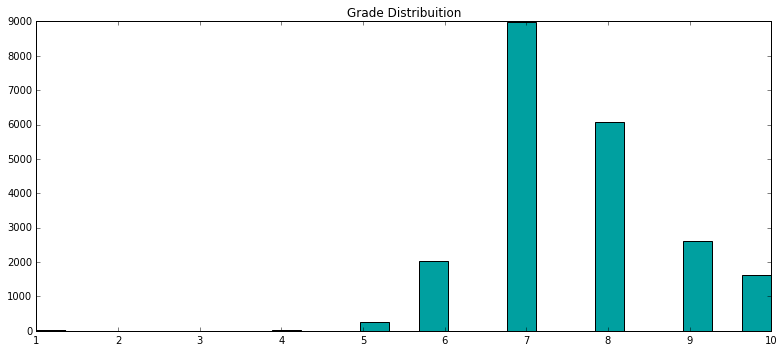

In [158]:
#check the grade variable distribution
print("Grade statistical summary: ")
print(house.grade.describe())

fig = plt.figure(figsize = (11,5));
ax = fig.add_subplot(1, 1, 1)
ax.hist(house['grade'], bins = 25, color = '#00A0A0')
plt.title('Grade Distribuition')
#ax = fig.add_subplot(1, 2, 2)
#ax.hist(house['price'], bins = 25, color = '#00A0A0')
#plt.title('Price Distribuition')
fig.tight_layout()
fig.show()


Secondly, I will check the heat map to get an overall understanding of the relationship between features.

From the heat map result, we can tell the major features those would impact grade include: sqft_above, sqft_living15, sqft_living, bathrooms, price, bedrooms,yr_built,floor.

The most unrelated features are condition, zipcode, yr_renovated, lat, waterfall, sqft_lot15,sqft_lot, view, sqft_basement, long.

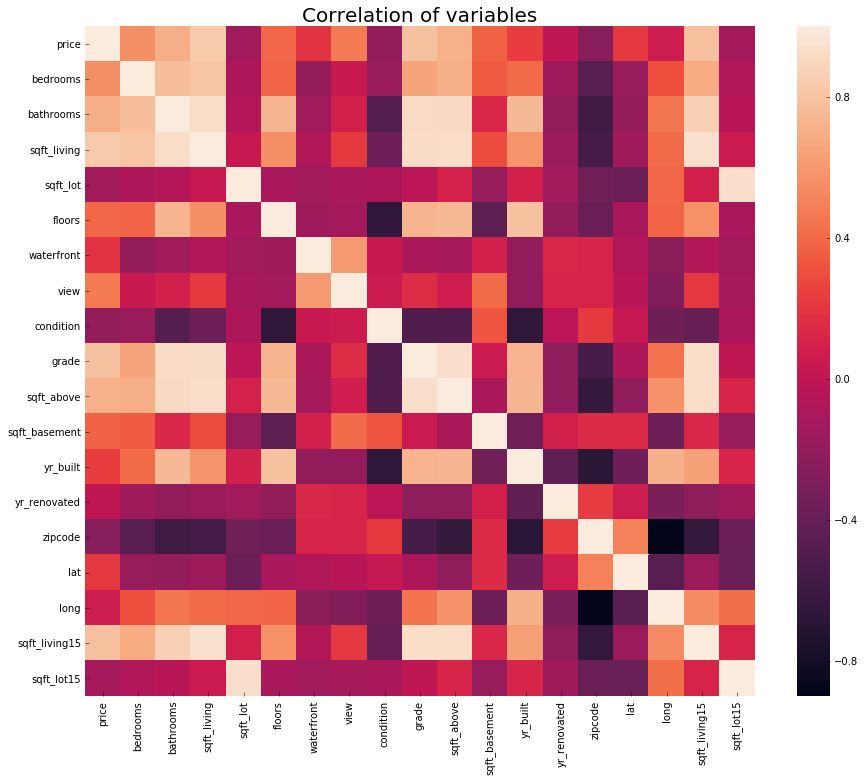

In [142]:
plt.figure(figsize=(15,12))
plt.title('Correlation of variables', fontsize=20)
sns.heatmap(house.corr().astype(float).corr(),vmax=1.0)
plt.show()

I try the pair plot to check the relationship among grade and those top 4 impactful features (sqft_above, sqft_living15, bathrooms, price). I am considerring sqft_living15 and sqft_living represent similar info here.

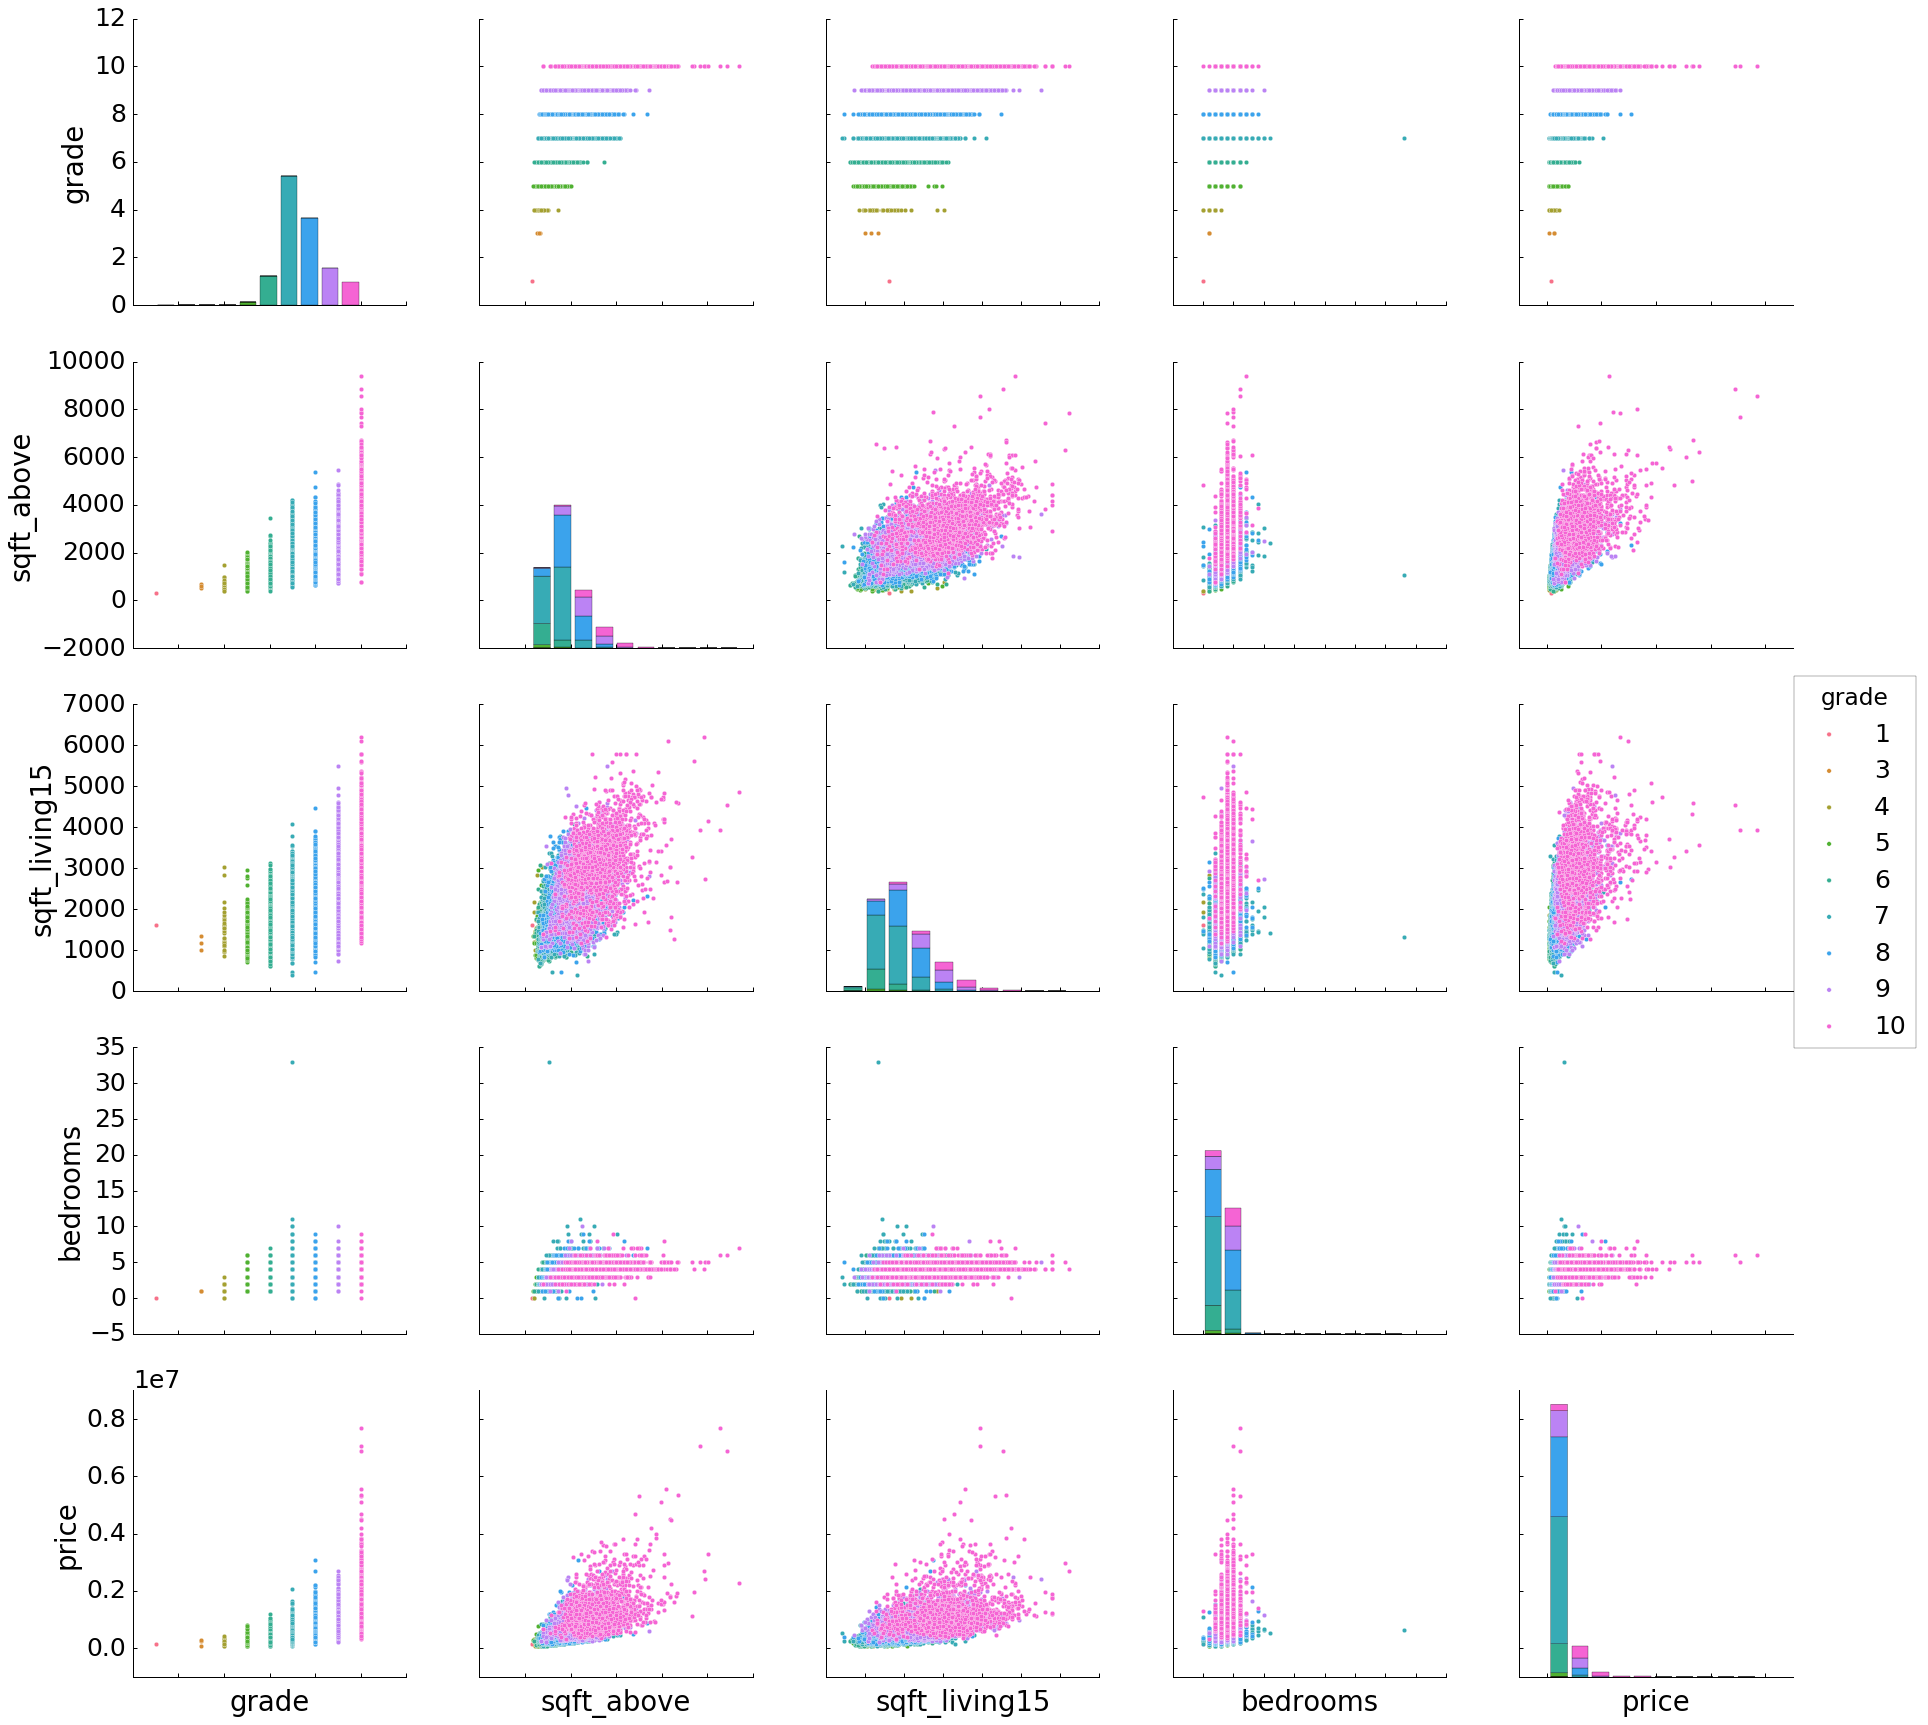

In [143]:
#statistical relationship among grade and lot size, living size, bedroom number, price.
with sns.plotting_context("notebook",font_scale=2.5):
    g = sns.pairplot(house[['grade','sqft_above','sqft_living15','bedrooms','price']], 
                 hue='grade', palette='husl',size=5)
g.set(xticklabels=[]);

From the pair plot, we can see low score houses have small lot and living space. and accordingly less bedrooms and lower prices. 
Now I will study the rest 3 features (bedrooms,yr_built,floor) in the impactful feature list.

In [139]:
cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(house['bathrooms'], house['grade']).style.background_gradient(cmap = cm)

grade,1,3,4,5,6,7,8,9,10
bathrooms,,,,,,,,,
0.0,1,2,0,0,0,4,2,0,1
0.5,0,0,0,1,2,0,1,0,0
0.75,0,1,14,14,26,17,0,0,0
1.0,0,0,14,190,1414,2084,143,7,0
1.25,0,0,0,0,1,3,2,2,1
1.5,0,0,0,9,137,984,288,23,5
1.75,0,0,1,9,225,1899,808,92,14
2.0,0,0,0,17,184,1165,458,93,13
2.25,0,0,0,0,4,778,956,237,72


Grade less than 8 is more likely to have 1 bathroom while grade greater than 7 is more likely to have 2.5 bathrooms.

In [145]:
cm = sns.light_palette("blue", as_cmap=True)
pd.crosstab(house['floors'], house['grade']).style.background_gradient(cmap = cm)

grade,1,3,4,5,6,7,8,9,10
floors,,,,,,,,,
1.0,1,3,27,202,1662,5916,2233,447,189
1.5,0,0,2,38,311,1006,402,105,46
2.0,0,0,0,2,63,1943,2989,1935,1309
2.5,0,0,0,0,2,15,53,46,45
3.0,0,0,0,0,0,100,385,82,46
3.5,0,0,0,0,0,1,6,0,1


There is a clear change when grade goes up to 8. Grade less than 8 is more likely to have 1 fllor while grade greater than 7 is more likely to have 2 floors.

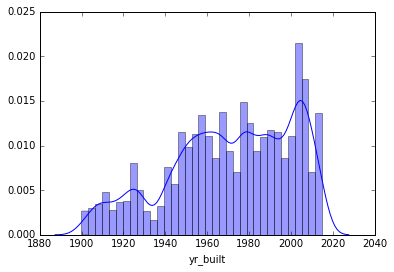

In [141]:
sns.distplot(house.yr_built)

From the house built year distribution, we can see more houeses built in 2012 than other years.

To proof the weak relationship between grade and those unrelated features found in heat map, I will take the condition as an example and will check its distribution.

Condition counting: 
3    14031
4     5679
5     1701
2      172
1       30
Name: condition, dtype: int64


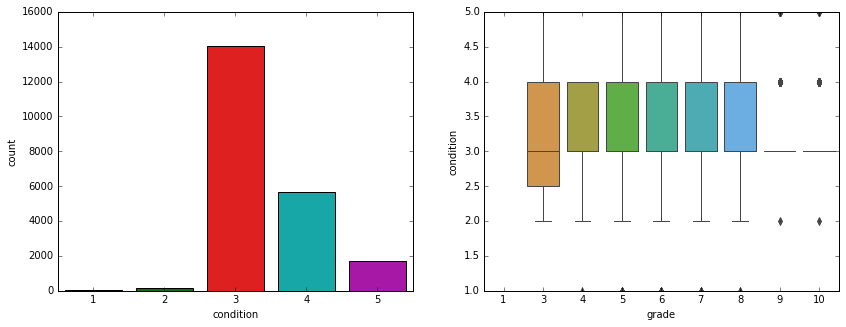

In [149]:
condition = house['condition'].value_counts()

print("Condition counting: ")
print(condition)

fig, ax = plt.subplots(ncols=2, figsize=(14,5))
sns.countplot(x='condition', data=house, ax=ax[0])
sns.boxplot(x='grade', y= 'condition', data=house, ax=ax[1])
plt.show()

Condition has the same distribution for grade score from 3 to 8. It indeed has not strong relationship with grade. 
Now I will study the relationship of the rest 

### What are the busiest times of the year to buy/sell house in Seattle?

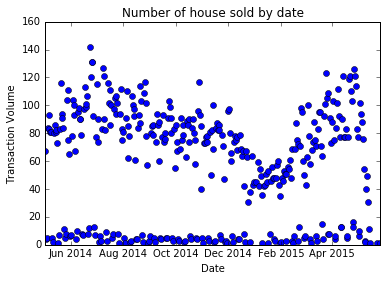

In [5]:
tran_day=house.groupby(['date']).size().reset_index(name='counts')
plt.plot_date(tran_day['date'],tran_day['counts'])
plt.title('Number of house sold by date')
plt.xlabel('Date')
plt.ylabel('Transaction Volume')

<Container object of 7 artists>

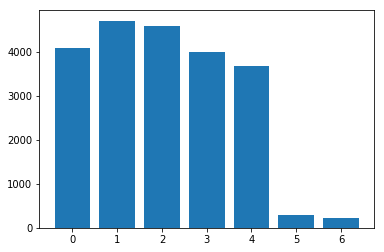

In [101]:
house['weekday']=house['date'].dt.dayofweek
tran_week=house.groupby(['weekday']).size().reset_index(name='counts')
plt.bar(tran_week['weekday'],tran_week['counts'])
plt.title('Number of house sold by day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Transaction Volume')

From the number of house solde by date, we can see, In General, the transaction volume dropped to the lowest point in winter 
and reached the highest point in summer.

There are some low transaction days evenly distributed along the year. By checking the transaction volumn by day of the week, 
we can the low points are the weekend. And interestingly, Tuesday is the day with most transactions.

### Predict house grade based on the given features

I Prepare training and test data before we jump into algorithms. From the section 1, I learnt that the top 4 features having the strongest relationsihp with grade are sqft_above, sqft_living15, bathrooms, price. So I will choose only the four features to train the model from the efficency standpoint.
#### Data Preprocessing

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

grade_final=house['grade']

feature_raw=house.drop(['date','grade'],axis=1)
feature_raw_short=house.loc[:,('sqft_above', 'sqft_living15', 'bathrooms', 'price','bedrooms','yr_built','floors')]
#feature_raw.groupby(['BuildYearBin'])['BuildYearBin'].count().plot(kind='bar',label='0')
#feature_log_transformed=pd.DataFrame(feature_raw)
#feature_log_transformed['price'] = feature_raw['price'].apply(lambda x: np.log(x + 1))
#feature_log_minmax_transform = pd.DataFrame(data = feature_log_transformed)
#feature_log_minmax_transform['price'] = scaler.fit_transform(feature_log_transformed['price'])

feature_final = pd.get_dummies(feature_raw)
feature_final = StandardScaler().fit_transform(feature_final) # increased the score from 55 to 65

feature_final_short = pd.get_dummies(feature_raw_short)
feature_final_short = StandardScaler().fit_transform(feature_final_short) # increased the score from 55 to 65
# Split the 'features' and 'grade_raw' data into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature_final, 
                                                    grade_final, 
                                                    test_size = 0.2)

X_train_short, X_test_short, y_train_short, y_test_short = train_test_split(feature_final_short, 
                                                    grade_final, 
                                                    test_size = 0.2)

Instead of starting with linear regression model, I chose more advanced and embedded methods including KNN, Adaboost classifier, Decision tree regressor, SVM, Random Forest Regressor and Extreme Gradient Boosting Regressor for comparison. 
#### Implementation

In [69]:
from sklearn.linear_model import LinearRegression

LR=LinearRegression()
LR.fit(X_train, y_train)
#y_pred = LR.predict(X_test)
print("full feature R2 score: {}".format(LR.score(X_test,y_test))) # coefficient of determination R^2 of the prediction.
LR.fit(X_train_short, y_train_short)
print("key feature R2 score: {}".format(LR.score(X_test_short,y_test_short))) # coefficient of determination R^2 of the prediction.

full feature R2 score: 0.6926802122848252
key feature R2 score: 0.6874085971260806


In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score
KNN = KNeighborsClassifier(n_neighbors=11)
KNN.fit(X_train, y_train)
KNN.score(X_test,y_test)

0.64769835762202177

In [77]:
from sklearn.ensemble import AdaBoostClassifier
AB = AdaBoostClassifier() 
AB.fit(X_train, y_train)
AB.score(X_test,y_test)

0.46865602590793431

In [78]:
from sklearn.tree import DecisionTreeRegressor
DT = DecisionTreeRegressor() 
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
print(DT.score(X_test, y_test))

0.627255170255


In [80]:
#support vector, it taks long calculation time
from sklearn.svm import SVR 
svr = SVR() 
svr.fit(X_train, y_train)
y_pred =svr.predict(X_test)
svr.score(X_test, y_test)

0.76863446897788923

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
RF = RandomForestRegressor() 
RF.fit(X_train, y_train)
RF.score(X_test, y_test)
RF_short = RandomForestRegressor() 
RF_short.fit(X_train_short, y_train_short)

print("full feature R2 score: {}".format(RF.score(X_test,y_test))) # coefficient of determination R^2 of the prediction.
print("Key feature R2 score: {}".format(RF_short.score(X_test_short, y_test_short))) # coefficient of determination R^2 of the prediction.


full feature R2 score: 0.7883542574551169
Key feature R2 score: 0.7516003116603422


In [89]:
#Extreme Gradient Boosting
import xgboost
from sklearn.metrics import classification_report
clf = xgboost.XGBClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         1
          4       0.33      0.20      0.25         5
          5       0.60      0.11      0.18        56
          6       0.67      0.50      0.57       426
          7       0.74      0.82      0.78      1787
          8       0.64      0.64      0.64      1191
          9       0.54      0.52      0.53       513
         10       0.73      0.70      0.71       344

avg / total       0.68      0.69      0.68      4323



C:\Users\linhu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Interesting to see linear algorithm performs better than KNN in respect of the R2 score. KNN is better than ada boost classifier. Among regressor algorithms, random forest regressor has the highest r2 score. 

By cutting the features down to the top 7 key features, we can see the linear model score dropped from 0.69 to 0.68 which is acceptable. While for the Random forest regressor, the R2 score dropped from 0.79 to 0.75 by cutting off features down.

I will use the random grid grid to find the best hyperparameters for random forest regressor to increase the score for random forest regressor.
#### Refinement

In [61]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': range(400,1000,100),
               'max_features': ['log2'],
               'max_depth': range(10, 40, 5),
               'min_samples_split': [2, 4, 8],
               'min_samples_leaf': [1, 2, 4]
              }

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RF, 
                               param_distributions = random_grid, 
                               n_iter = 10,                                
                               #verbose=2, 
                               #random_state=42, 
                               #n_jobs = -1
                              )
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_
rf_random.score(X_test,y_test)

{'n_estimators': 800,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 30}

In [82]:
y_pred_tuned = rf_random.predict(X_test)
r2_score(y_pred_tuned, y_test)
rf_random.score(X_test,y_test)

0.92196837134018705

THe searching grid find the best hyperparameter and increased the score to 0.92 which is very optimistic.  

# Conclusion

here is what I have learned from this project.
1. sqft_above, sqft_living15, bathrooms, price are the four key features determine the house grade.
2. Seattle people like to buy/sell house in summer. And by week, Tuesday is the day with most transactions.
3. Random forest regressor model has the highest R2 score comparing to linear regression, SVM, KNN, XGBoost and adabooster algorithms. I used grid searching and it pumped score from 0.7 to 0.9.

### Reflection
The major process steps are
1. Find the initial public relevant dataset
2. explored and preprocessed the data (lots of learning in visulizations)
3. created benchmark classifier
4. trained the classifier using the training data. (most interesting section with lots of try out)
5. pick up the best performer algorithm based on the R2 score.
6. searching grid to find the best hyperparameter with random forest regressor.
7. test out the model with searching grid result.

Something interesting to find is linear regression worked better than ada bosster with default parameter. 

By adding more features will not improve the model a lot if the features are redundant. e.g. sqrt_living and sqrt.

calculation load is not a big problem here given only 21.6k records. except SVM, I did not see a big difference in calculation time. The searching grid takes some time to try out the best combination. 

### next step
I would like to test the model with some more data in the future if I can find similar data after 2015. 